In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import os, sys
import tensorflow as tf

from sklearn.mixture import GaussianMixture
from sklearn.externals import joblib

%matplotlib inline
%config InlineBackend.figure_format = 'jpg'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

data = pd.read_excel('../data/record50.xlsx', sheet_name=1, header=0, index_col=0)

# 抽取歌曲的转场点时刻
recordpoint = []
for i in range(data.shape[0]):
    d = data.iloc[i].values
    tmp = []
    for s in d[2:-1]:
        if s is np.nan:
            continue
        s = s.split('\n')
        for si in s:
            st = si.split('-')
            for t in st:
                if t not in tmp:
                    tmp.append(t)
    tmp = sorted(tmp)
    recordpoint.append(",".join(tmp))
    
data['歌曲转折时间点'] = pd.Series(recordpoint, index=data.index)
data

/Users/JJjie/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


,歌曲（4/4拍·抒情流行音乐）,歌曲转折时间点,开头/前奏 Introduction,主歌 Verse,预副歌 Pre-chorus,副歌 Chorus,桥段 Bridge,结尾 Outro/Conclusion,乐器独奏 ElisionInstrumental Solo
序号,,,,,,,,,
0,彩虹,"00:00,00:12,01:29,01:56,02:47,03:14,03:38,04:0...",00:00-00:12,00:12-01:29\n01:56-02:47,NaN,01:29-01:56\n02:47-03:14\n03:38-04:09,03:14-03:38,04:09-04:23,(此列暂时不用)
1,孤独患者,"00:00,00:16,00:48,01:31,01:39,02:09,02:54,03:2...",00:00-00:16\n01:31-01:39\n02:54-03:21,00:16-00:48\n01:39-02:09,NaN,00:48-01:31\n02:09-02:54\n03:21-04:07,NaN,04:07-04:32,NaN
2,你的背包,"00:00,00:22,00:52,01:21,01:26,01:56,02:25,02:4...",00:00-00:22\n01:21-01:26\n02:25-02:49,00:22-00:52\n01:26-01:56,NaN,00:52-01:21\n01:56-02:25\n02:49-03:30,NaN,03:30-03:57,NaN
3,伤信,"00:00,00:23",00:00-00:23,NaN,NaN,NaN,NaN,NaN,NaN
4,淘汰,"00:00,00:34,01:37,02:10,02:24,02:54,03:28,03:4...",00:00-00:34\n02:10-02:24\n03:28-03:43,00:34-01:37\n02:24-02:54,NaN,01:37-02:10\n02:54-03:28\n03:43-04:18,NaN,04:18-04:45,NaN
5,K歌之王,"00:00,00:13,01:03,01:44,01:54,02:20,02:43,02:5...",00:00-00:13\n01:44-01:54,00:13-01:03\n01:54-02:20,NaN,01:03-01:44\n02:20-02:43\n02:55-03:07,02:43-02:55,03:07-03:38,NaN
6,我总是一个人在练习一个人,"00:00,00:14,01:14,01:48,02:03,02:36,03:03",00:00-00:14\n01:48-02:03,00:14-01:14,NaN,01:14-01:48\n02:03-02:36,NaN,02:36-03:03,NaN
7,石榴石,"00:00,00:12,00:41,01:05,01:44,01:50,02:19,02:4...",00:00-00:12\n01:44-01:50\n03:23-03:44,00:12-00:41\n01:50-02:19,00:41-01:05\n02:19-02:43\n03:44-04:12,01:05-01:44\n02:43-03:23\n04:12-04:43,NaN,04:43-05:19,NaN
8,老人与海,"00:00,00:36,00:58,01:19,01:41,02:03,02:24,02:4...",00:00-00:36\n02:46-03:07,00:36-00:58\n01:41-02:03\n03:07-03:30,NaN,01:19-01:41\n02:24-02:46,00:58-01:19\n02:03-02:24,03:30-04:27,NaN


In [64]:
# 基因
class Gene:
    def __init__(self, music_path, music_type, gene_num=6):
        self.path = music_path
        self.type = music_type
        self.gene_num = gene_num
        self.sl = 10 # 切分帧长 (1s 划分多少个片段)
        
    # 获取片段特征
    def getFeature(self, musicdata):
        return np.transpose([np.mean(musicdata, axis=1), np.mean(musicdata, axis=1), 
                                      np.max(musicdata, axis=1), np.min(musicdata, axis=1)])
    
    # 音乐数据处理
    def dataprocessing(self):
        files = os.listdir(self.path)
        self.musicData = []
        for name in files:
            if name == '.DS_Store':
                continue
            temp, sr = librosa.load(os.path.join(self.path, name))
            sr = int(sr / sl) # 片段长度 2205

            # 在时间轴上切割出数据
            num_slice = int(temp.shape[0] / sr)
            temp = temp[:num_slice * sr]
            tempslice = np.split(temp, num_slice, 0)
            self.musicData += tempslice    
        self.musicData = np.array(self.musicData, dtype=np.float32)
        self.geneData = self.getFeature(self.musicData)
        print(self.geneData.shape)
        
    # 训练基因
    def traingene(self):
        self.gene_num = gene_num
        # 聚类基因数
        clu = GaussianMixture(n_components=gene_num, covariance_type='diag')
        clu.fit(self.geneData)
        # store model
        joblib.dump(clu, './model/clu_{}.model'.format(self.type))
        
    # 基因画图
    def geneplot(self):
        clu = joblib.load('./model/clu_{}.model'.format(self.type))
        geneassign = clu.predict(x)
        fig, axes = plt.subplots(2, 3, figsize=(15, 7))
        
        plotdata = []
        for i in range(self.gene_num):
            temp = genedata[geneassign == i]
            temp = np.mean(temp, axis=0)
            plotdata.append(temp)
            
        temp = np.std(plotdata, axis=1)
        index = []
        for i in range(gene_num):
            index.append((i, temp[i]))
        index.sort(key=lambda x:x[1])
        self.gene_index = [x[0] for x in index]

        for i in range(gene_num):
            m = int(i / 3)
            n = int(i % 3)

            temp = plotdata[self.gene_index[i]]
            axes[m, n].plot(range(2205), temp)
            axes[m, n].set_title("gene_{}".format(i))
            axes[m, n].set_yticks(np.arange(-0.04, 0.04, 0.01))

        plt.show()
        
    # 画出音乐与基因
    def musicplot(self):
        clu = joblib.load('./model/clu_{}.model'.format(self.type))
        files = os.listdir(self.path)
        for name in files:
            if name == '.DS_Store':
                continue
            tempdata, sr = librosa.load(os.path.join(self.path, name))
            # 获取音乐时长
            t = librosa.get_duration(tempdata, sr)
            # 获取节拍
            tempo, beats = librosa.beat.beat_track(y=tempdata, sr=sr)
            y_beats = librosa.clicks(frames=beats, sr=sr)
            # 节拍对应时间
            times = librosa.frames_to_time(beats, sr=sr)
            # 获取基因数据
            num_slice = int(tempdata.shape[0] / int(sr/self.sl))
            tempx = tempdata[:num_slice * int(sr/self.sl)]
            tempx = np.split(tempx, num_slice, 0)
            tempx = self.getFeature(tempx)
            G = clu.predict_proba(tempx)
            G = G[:, self.gene_index]

            f, axes = plt.subplots(2, 1, figsize=(30, 6))

            # 画出mfcc曲线
            librosa.display.waveplot(tempdata, sr=sr, x_axis='time', ax=axes[0])

            # 画出基因数据
            plotdata = np.transpose(G)
            print(plotdata.shape)
            sns.heatmap(plotdata, vmin=0, vmax=1, linewidths=0., cbar=False, ax=axes[1])
            span = axes[0].get_xticks()
            span = span[1] - span[0]
            axes[1].set_xticks(range(0, plotdata.shape[1], int(span * sl)))
            axes[1].set_xticklabels(axes[0].get_xticklabels()[:-1])


            plt.show()

### 流行音乐

In [3]:
# 训练基因
music_path = '../data/music/'
files = os.listdir(music_path)
sl = 10
genedata = []
for i in range(data.shape[0]):
    d = data.iloc[i].values
    name = d[0] + '.mp3'
    if name in files:
        tempdata, sr = librosa.load(os.path.join(music_path, name))
        sr = int(sr / sl) # 片段长度 2205
        
        # 划分数据
        num_slice = int(tempdata.shape[0] / sr)
        tempdata = tempdata[:num_slice * sr]
        tempslice = np.split(tempdata, num_slice, 0)
        genedata += tempslice    
genedata = np.array(genedata, dtype=np.float32)
x = np.transpose([np.mean(genedata, axis=1), np.mean(genedata, axis=1), np.max(genedata, axis=1), np.min(genedata, axis=1)])
print(x.shape)



(7922, 4)


['./model/clu.model']

(7922,)
(1243, 2205)
(1557, 2205)
(1348, 2205)
(1235, 2205)
(1429, 2205)
(1110, 2205)


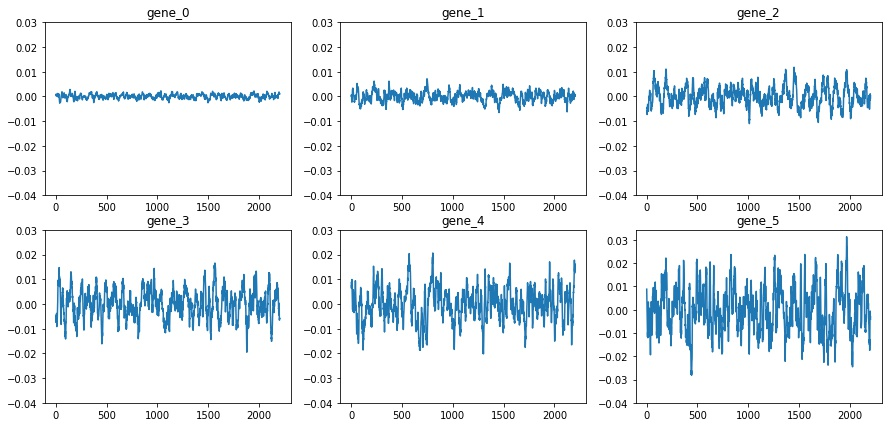

In [25]:
clu = joblib.load('./model/clu.model')
index = [2, 3, 0, 4, 5, 1]
geneassign = clu.predict(x)
print(geneassign.shape)
fig, axes = plt.subplots(2, 3, figsize=(15, 7))

for i in range(gene_num):
    m = int(i / 3)
    n = int(i % 3)
    
    temp = genedata[geneassign == index[i]]
    print(temp.shape)
    temp = np.mean(temp, axis=0)
    
    axes[m, n].plot(range(2205), temp)
    axes[m, n].set_title("gene_{}".format(i))
    axes[m, n].set_yticks(np.arange(-0.04, 0.04, 0.01))

plt.show()

彩虹.mp3
孤独患者.mp3
(6, 2734)


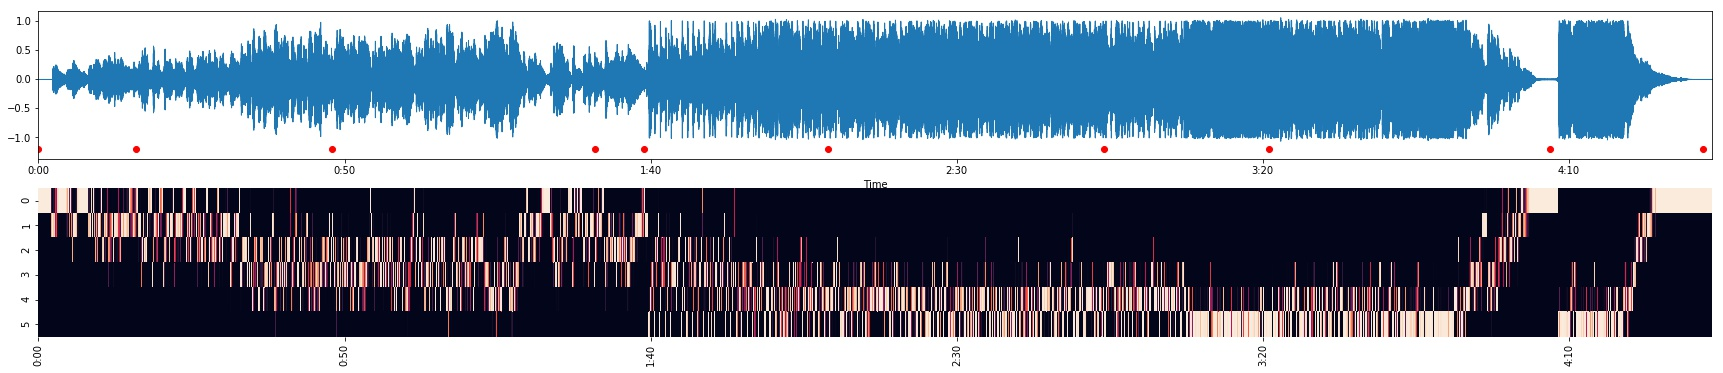

你的背包.mp3
(6, 2401)


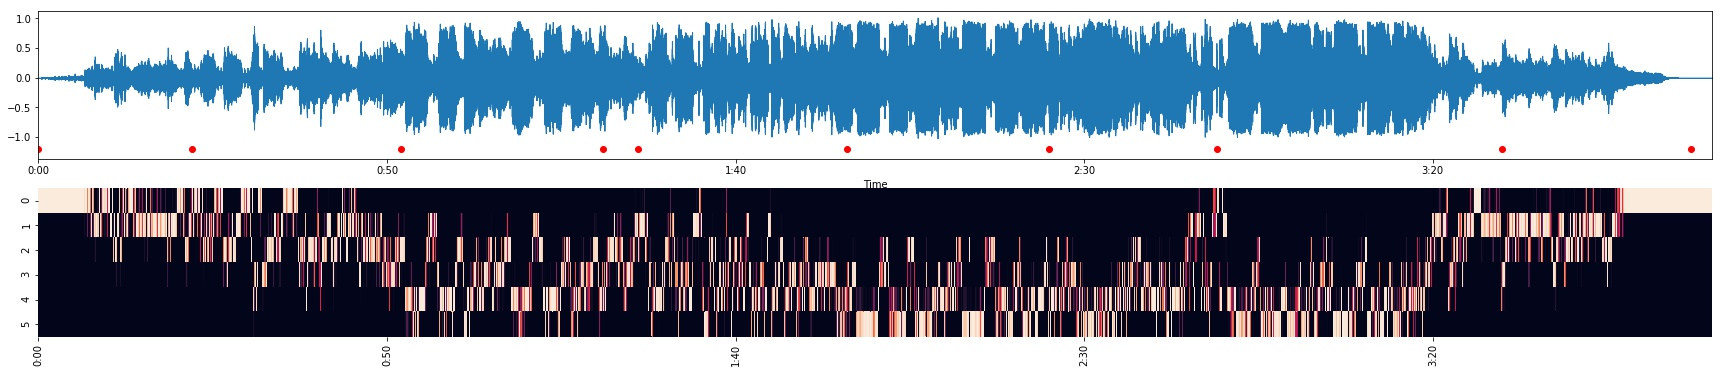

伤信.mp3
(6, 2787)


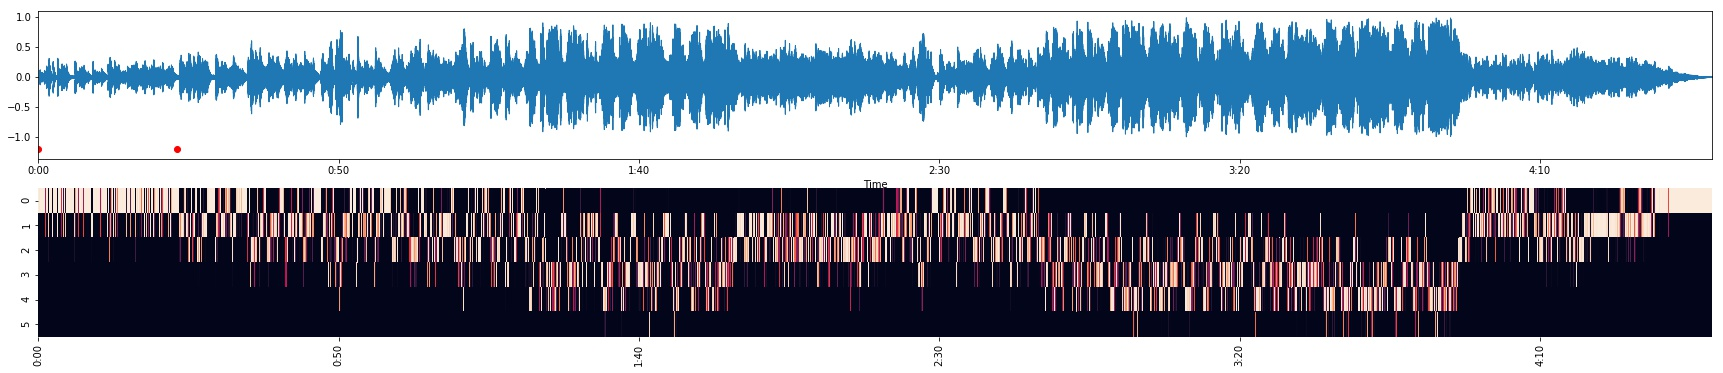

In [27]:
# 输出观察读取音乐的时间曲线
# 加载基因模型
sl = 10
music_path = '../data/music/'
files = os.listdir(music_path)

for i in range(4):
    d = data.iloc[i].values
    name = d[0] + '.mp3'
    points = d[1].split(',')
    print(name)
    if name in files:
        tempdata, sr = librosa.load(os.path.join(music_path, name))
        # 获取音乐时长
        t = librosa.get_duration(tempdata, sr)
        # 获取节拍
        tempo, beats = librosa.beat.beat_track(y=tempdata, sr=sr)
        y_beats = librosa.clicks(frames=beats, sr=sr)
        # 节拍对应时间
        times = librosa.frames_to_time(beats, sr=sr)
        # 获取基因数据
        num_slice = int(tempdata.shape[0] / int(sr/sl))
        tempx = tempdata[:num_slice * int(sr/sl)]
        tempx = np.split(tempx, num_slice, 0)
        tempx = np.transpose([np.mean(tempx, axis=1), np.mean(tempx, axis=1), np.max(tempx, axis=1), np.min(tempx, axis=1)])
        G = clu.predict_proba(tempx)
        G = G[:, index]
        
        f, axes = plt.subplots(2, 1, figsize=(30, 6))

        # 画出mfcc曲线
        librosa.display.waveplot(tempdata, sr=sr, x_axis='time', ax=axes[0])
        # 画出转场点
        for p in points:
            ps = p.split(":")
            p = int(ps[0]) * 60 + int(ps[1])
            axes[0].scatter(p, -1.2, c='r')
            
        # 画出基因数据
        plotdata = np.transpose(G)
        print(plotdata.shape)
        sns.heatmap(plotdata, vmin=0, vmax=1, linewidths=0., cbar=False, ax=axes[1])
        span = axes[0].get_xticks()
        span = span[1] - span[0]
        axes[1].set_xticks(range(0, plotdata.shape[1], int(span * sl)))
        axes[1].set_xticklabels(axes[0].get_xticklabels()[:-1])
        
        
        plt.show()

### 纯音乐

dataprocessing
(11502, 4)
train genes
plot genes


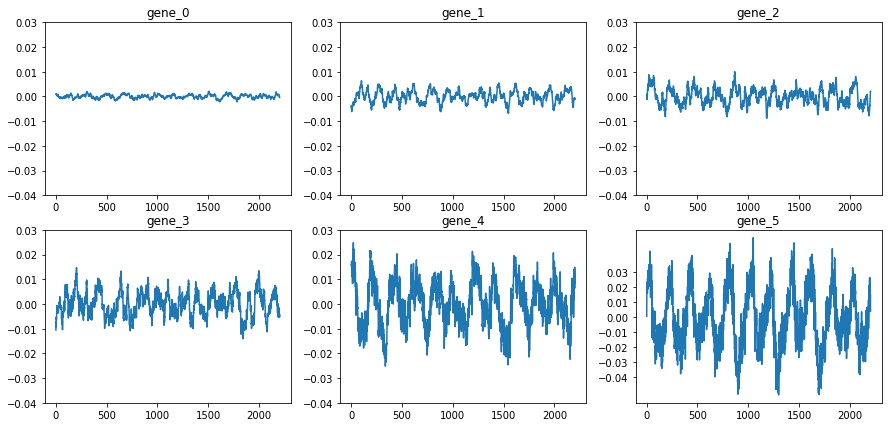

music plot
(6, 2007)


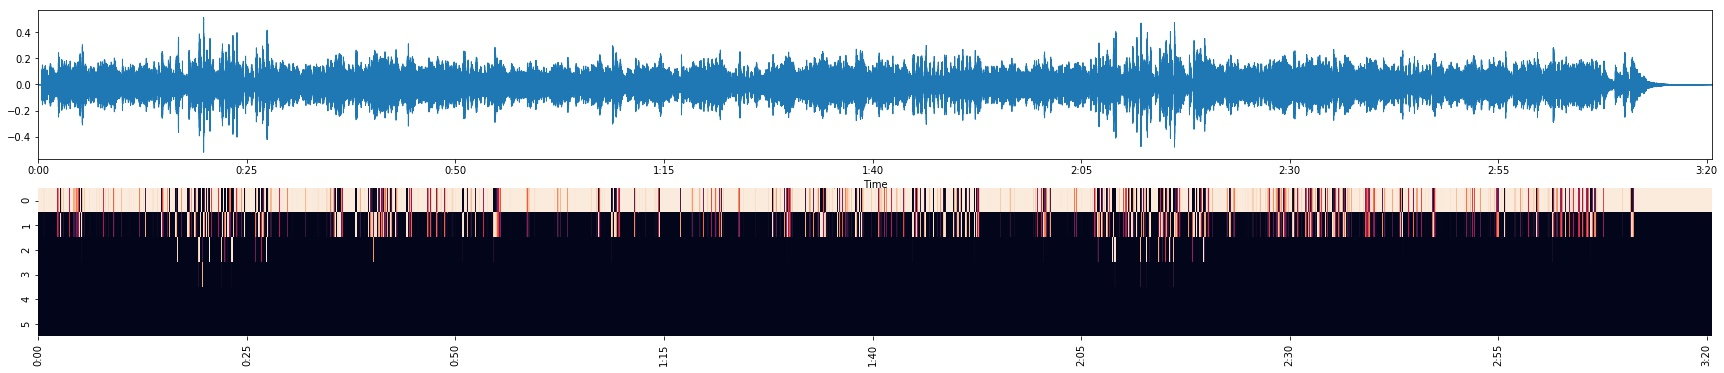

(6, 1361)


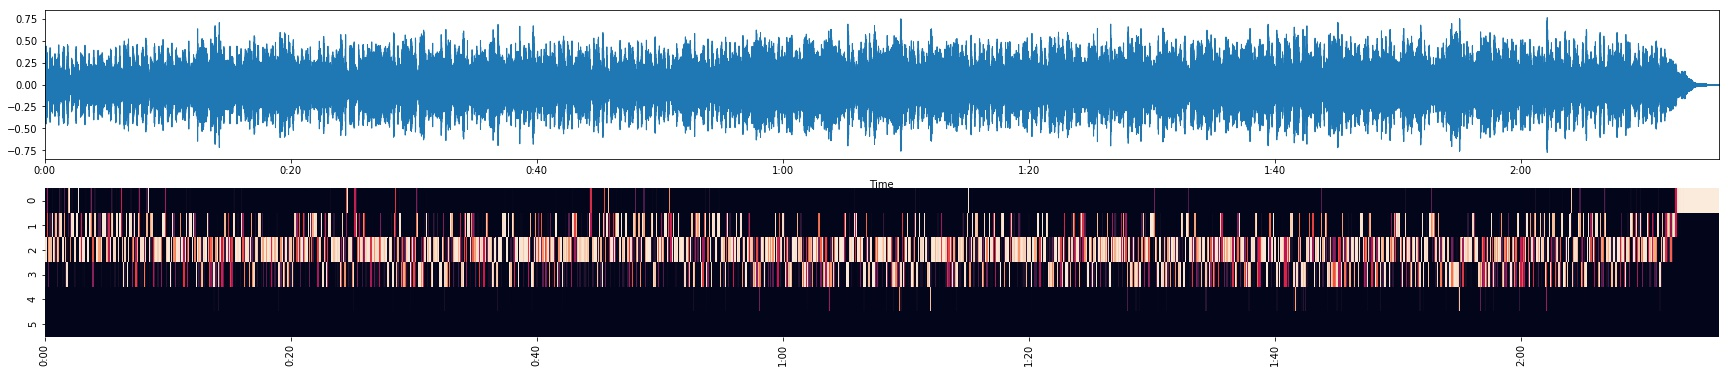

(6, 759)


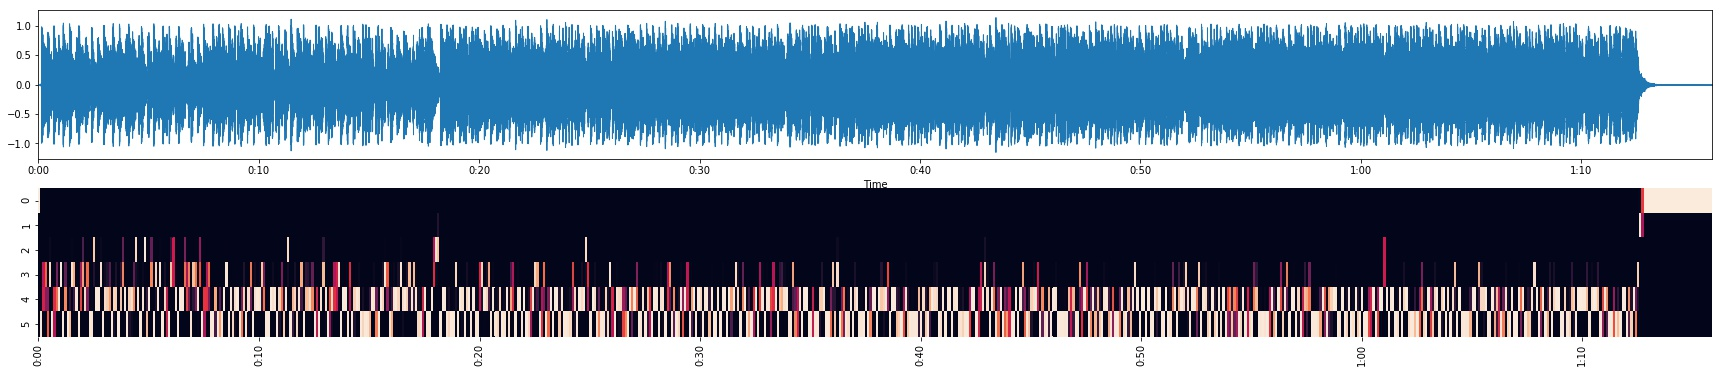

(6, 1319)


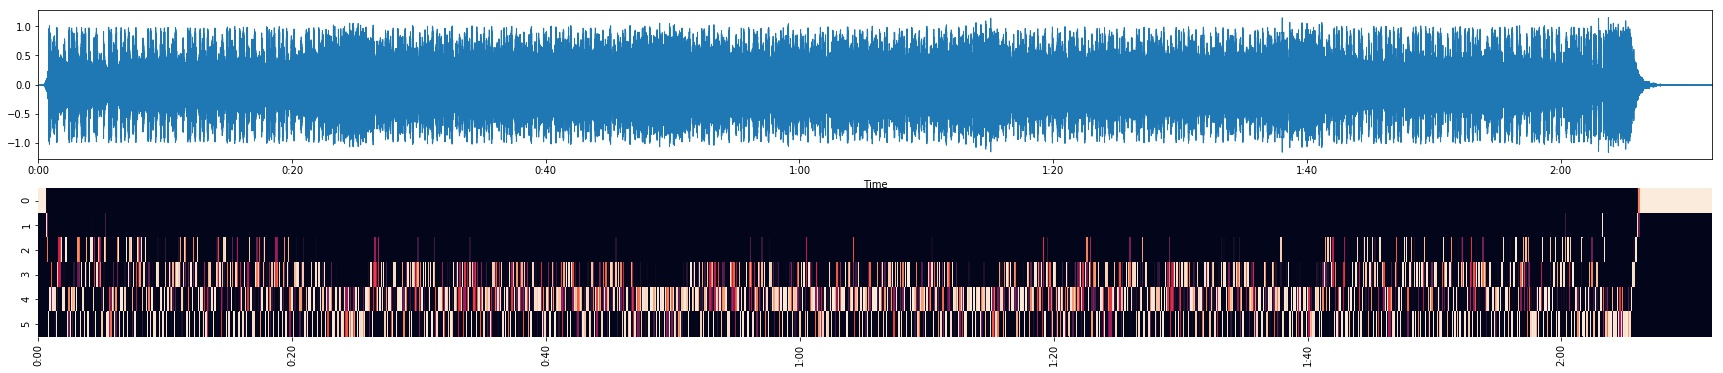

(6, 1249)


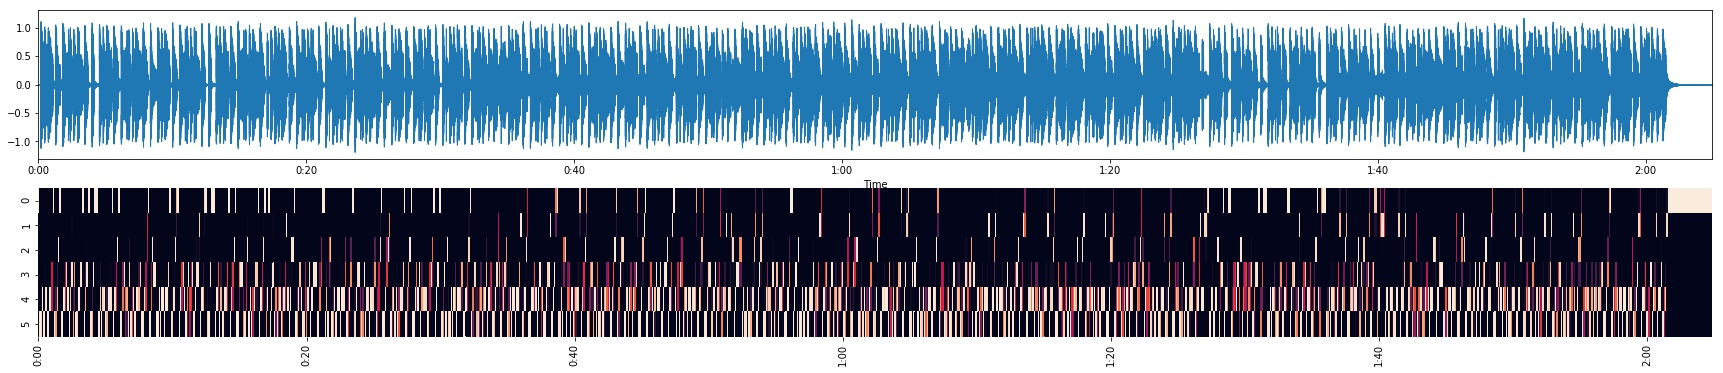

(6, 800)


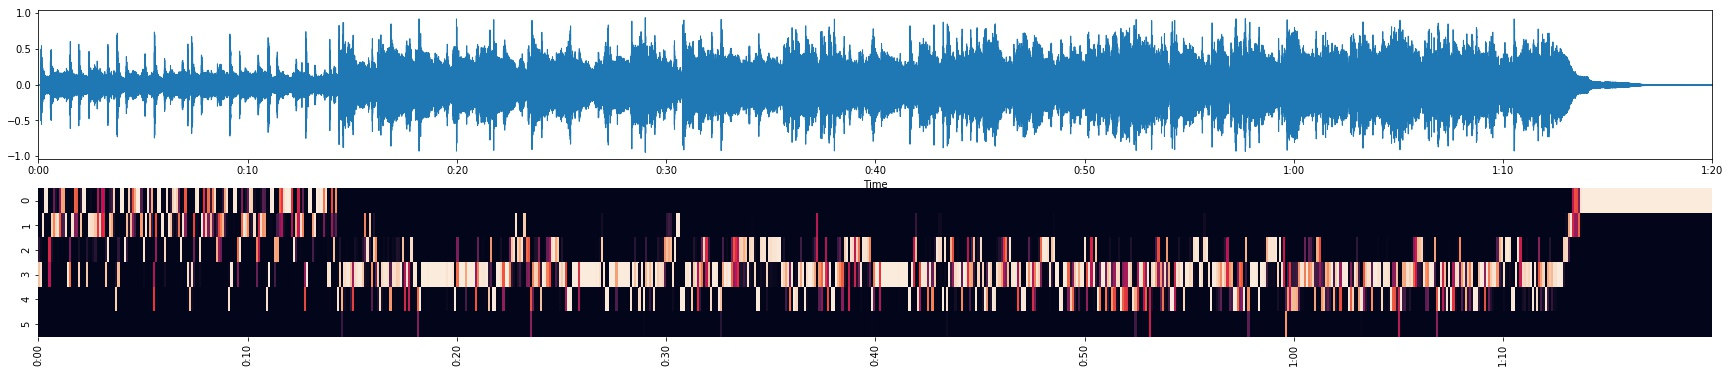

(6, 2747)


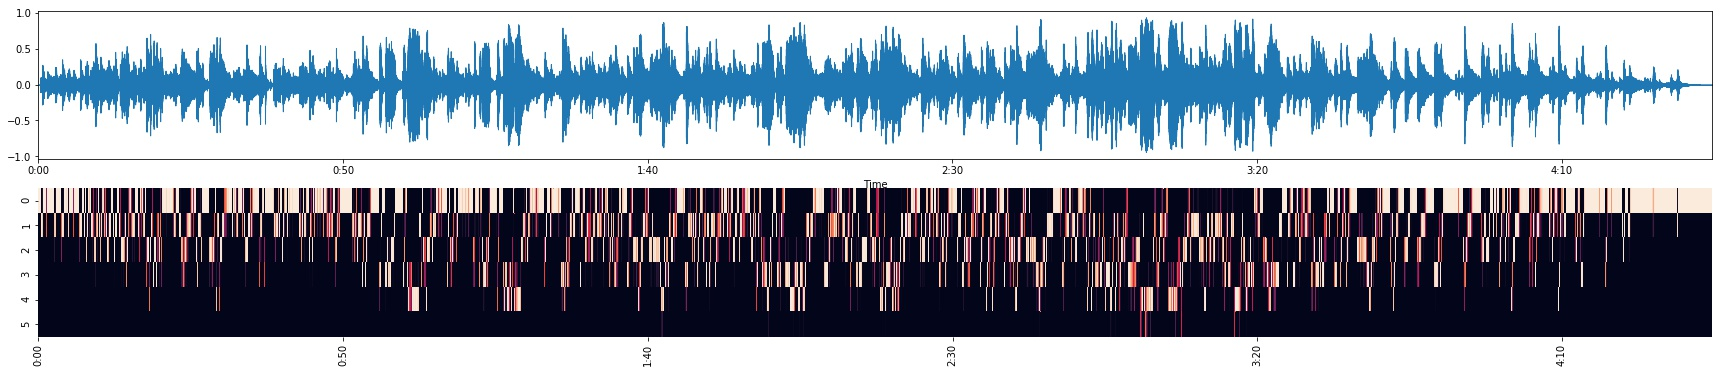

(6, 1260)


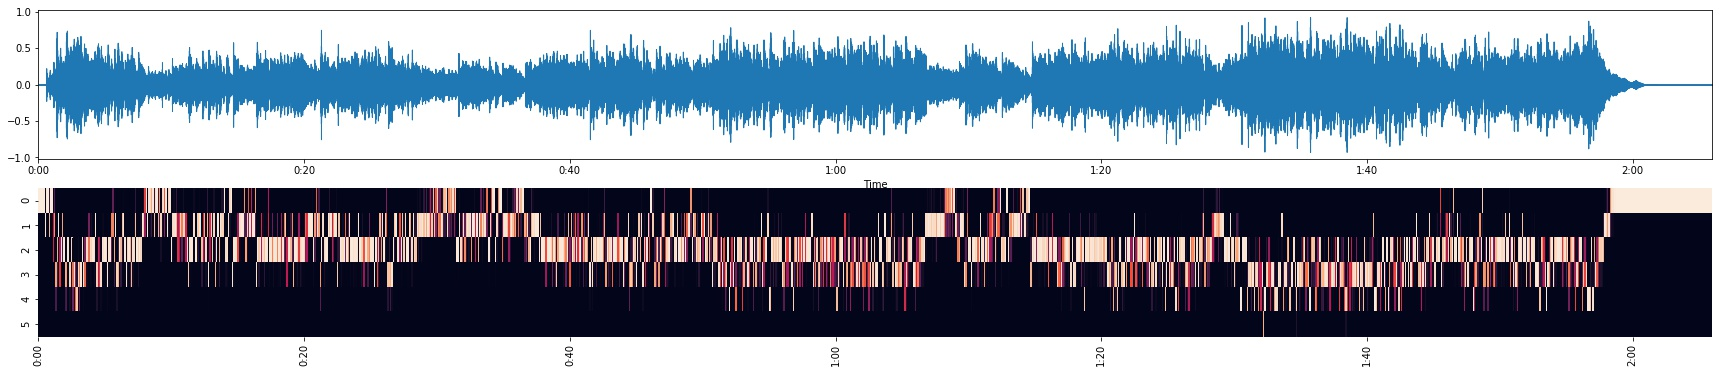

In [65]:
gene_pure_slow = Gene('../data/pure_music/快/', 'pure_slow', gene_num=6)
print('dataprocessing')
gene_pure_slow.dataprocessing()
print('train genes')
gene_pure_slow.traingene()
print('plot genes')
gene_pure_slow.geneplot()
print('music plot')
gene_pure_slow.musicplot()